In [0]:
import ast
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense, Dropout, Embedding, GlobalMaxPool1D, Input, LSTM
from keras.models import Model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
np.random.seed(93187)

In [0]:
!wget -q 'https://gitlab.com/pastalian/cheating-algorithmer/raw/master/data_en/problems-all.tsv'

In [0]:
LABELS = ['2-sat', 'binary search', 'bitmasks', 'brute force', 'chinese remainder theorem', 'combinatorics', 'constructive algorithms', 'data structures', 'dfs and similar', 'divide and conquer', 'dp', 'dsu', 'expression parsing', 'fft', 'flows', 'games', 'geometry', 'graph matchings', 'graphs', 'greedy', 'hashing', 'implementation', 'interactive', 'math', 'matrices', 'meet-in-the-middle', 'number theory', 'probabilities', 'schedules', 'shortest paths', 'sortings', 'string suffix structures', 'strings', 'ternary search', 'trees', 'two pointers']

In [0]:
df = pd.read_csv('problems-all.tsv', delimiter='\t')
df = df.dropna(subset=['difficulty'])
x, y = df['main_text'].values, df['tags'].values

In [0]:
y_tmp = []
for a in y:
  b = ast.literal_eval(a)
  tmp = [0] * len(LABELS)
  for i, l in enumerate(LABELS):
    tmp[i] = 1 if l in b else 0
  y_tmp += [tmp]
y = np.asarray(y_tmp)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                     random_state=93187)

In [0]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
x2_train = tokenizer.texts_to_sequences(x_train)
x2_test = tokenizer.texts_to_sequences(x_test)

In [0]:
MAX_LEN = 512
x3_train = sequence.pad_sequences(x2_train, maxlen=MAX_LEN)
x3_test = sequence.pad_sequences(x2_test, maxlen=MAX_LEN)

In [0]:
embed_size = 16
dim = int(embed_size / 2);

inp = Input(shape=(MAX_LEN, ))
x = Embedding(max_features, embed_size, mask_zero=False)(inp)
x = LSTM(dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(dim, kernel_regularizer=keras.regularizers.l2(0.001),
                   activation='relu')(x)
x = Dense(len(LABELS), activation="softmax")(x)

In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 512, 16)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 512, 8)            800       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 36)                324 

In [0]:
batch_size = 128
epochs = 16
history = model.fit(x3_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_split=0.2)

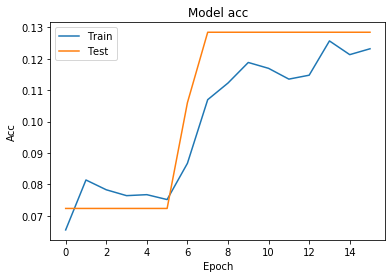

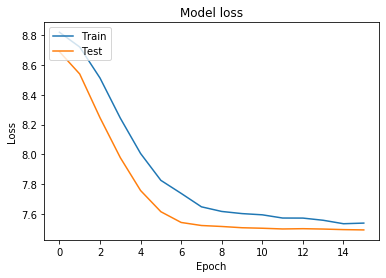

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
scores = model.evaluate(x3_test, y_test)
print(scores)

1003/1003 [==============================] - 16s 16ms/step
[7.400827912247906, 0.11665004988016184]


In [0]:
y_pred = model.predict(x3_test)

In [34]:
matched = 0
for x, y in zip(y_pred, y_test):
  idx = np.argmax(x)
  if y[idx] == 1:
    matched += 1

print('matched:', matched)
print('acc:', matched / len(y_test))

matched: 306
acc: 0.3050847457627119
